In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [2]:
data_dir = r'D:\JupyterNote\002_Notebook\dataset_roti\train'
image_size = (224, 224)
batch_size = 16
num_folds = 5
num_epochs = 10

In [3]:
# Load filenames and labels
def load_dataset(directory):
    classes = sorted(os.listdir(directory))
    file_paths = []
    labels = []
    for label, class_dir in enumerate(classes):
        class_dir = os.path.join(directory, class_dir)
        for fname in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(str(label))  # Convert label to string
    return np.array(file_paths), np.array(labels), classes

# Load dataset
file_paths, labels, classes = load_dataset(data_dir)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [4]:
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []
models = [] 

for train_index, val_index in kf.split(file_paths):
    print(f'Fold {fold_no}')

    # Split dataset into train and validation sets
    train_files, val_files = file_paths[train_index], file_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Data generators
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Model MobileNetV3
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(classes), activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # Simpan model ke dalam list
    models.append(model)
    
    # Evaluate model on validation data
    scores = model.evaluate(val_generator)
    accuracy_per_fold.append(scores[1] * 100)  # Akurasi dalam persen
    loss_per_fold.append(scores[0])

    print(f"Fold {fold_no} - Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

    fold_no += 1

Fold 1
Found 532 validated image filenames belonging to 2 classes.
Found 134 validated image filenames belonging to 2 classes.
Epoch 1/10


d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 483ms/step - accuracy: 0.6542 - loss: 4.4906 - val_accuracy: 0.8881 - val_loss: 2.8621 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 494ms/step - accuracy: 0.9114 - loss: 2.5028 - val_accuracy: 0.9478 - val_loss: 1.9343 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 504ms/step - accuracy: 0.9435 - loss: 1.8115 - val_accuracy: 0.9776 - val_loss: 1.4324 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.9488 - loss: 1.3958 - val_accuracy: 0.9776 - val_loss: 1.1529 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.9677 - loss: 1.1217 - val_accuracy: 0.9701 - val_loss: 0.9640 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 513ms/step - accuracy: 0.9451 - loss: 0.9489 - val_accuracy: 0.9552 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.9633 - loss: 0.8233 - val_

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.7383 - loss: 4.1943 - val_accuracy: 0.9023 - val_loss: 2.7615 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - accuracy: 0.9514 - loss: 2.3830 - val_accuracy: 0.9173 - val_loss: 1.9579 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.9484 - loss: 1.7185 - val_accuracy: 0.8872 - val_loss: 1.6342 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.9387 - loss: 1.3517 - val_accuracy: 0.9323 - val_loss: 1.1765 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.9532 - loss: 1.0636 - val_accuracy: 0.9248 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.9801 - loss: 0.8170 - val_accuracy: 0.9098 - val_loss: 0.9203 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.9510 - loss: 0.7367 - val_

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.7694 - loss: 4.1218 - val_accuracy: 0.9323 - val_loss: 2.6074 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.9325 - loss: 2.4104 - val_accuracy: 0.9624 - val_loss: 1.7560 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.9471 - loss: 1.6837 - val_accuracy: 0.9774 - val_loss: 1.2992 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.9625 - loss: 1.2621 - val_accuracy: 0.9624 - val_loss: 1.0817 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.9378 - loss: 1.1110 - val_accuracy: 0.9624 - val_loss: 0.8878 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - accuracy: 0.9717 - loss: 0.8310 - val_accuracy: 0.9774 - val_loss: 0.7299 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.9664 - loss: 0.7458 - val_

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.6872 - loss: 4.1733 - val_accuracy: 0.9549 - val_loss: 2.5581 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.9165 - loss: 2.4079 - val_accuracy: 0.9699 - val_loss: 1.7143 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.9346 - loss: 1.6453 - val_accuracy: 0.9023 - val_loss: 1.5064 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - accuracy: 0.9279 - loss: 1.3453 - val_accuracy: 0.9774 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 0.9693 - loss: 1.0199 - val_accuracy: 0.9699 - val_loss: 0.8721 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step - accuracy: 0.9762 - loss: 0.8518 - val_accuracy: 0.9624 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.9721 - loss: 0.7073 - val_

d:\JupyterNote\AnacondaEnv\envs\notebook_latih\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 459ms/step - accuracy: 0.7031 - loss: 4.3013 - val_accuracy: 0.9323 - val_loss: 2.6707 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 415ms/step - accuracy: 0.9301 - loss: 2.4683 - val_accuracy: 0.9398 - val_loss: 1.8686 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step - accuracy: 0.9474 - loss: 1.7259 - val_accuracy: 0.9398 - val_loss: 1.4529 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 429ms/step - accuracy: 0.9564 - loss: 1.3004 - val_accuracy: 0.9474 - val_loss: 1.1082 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step - accuracy: 0.9628 - loss: 1.0462 - val_accuracy: 0.9699 - val_loss: 0.8870 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.9829 - loss: 0.8492 - val_accuracy: 0.9624 - val_loss: 0.7705 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 414ms/step - accuracy: 0.9336 - loss: 0.7864 - val_

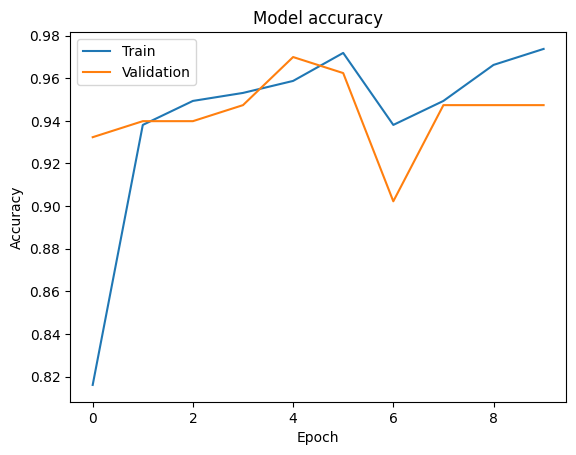

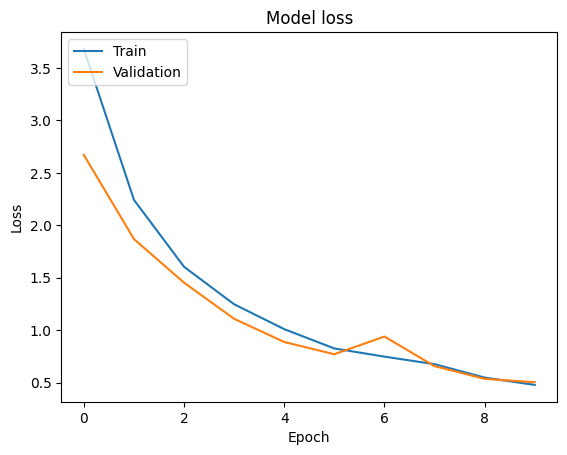

In [5]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [6]:
# Cetak rata-rata akurasi dan loss dari semua fold
print('\nAverage scores for all folds:')
print(f'Accuracy: {np.mean(accuracy_per_fold):.2f} (+/- {np.std(accuracy_per_fold):.2f})')
print(f'Loss: {np.mean(loss_per_fold):.2f}')


Average scores for all folds:
Accuracy: 95.20 (+/- 1.31)
Loss: 0.50


In [9]:
# Menghitung rata-rata bobot dari semua model
average_weights = []
for i in range(len(models[0].layers)):
    if isinstance(models[0].layers[i], Dense):
        weights = [model.layers[i].get_weights() for model in models]
        mean_weights = [np.mean([w[0] for w in weights], axis=0), np.mean([w[1] for w in weights], axis=0)]
        average_weights.append(mean_weights)

# Membuat model baru untuk menyimpan rata-rata bobot
base_model_avg = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_avg = base_model_avg.output
x_avg = GlobalAveragePooling2D()(x_avg)
x_avg = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x_avg)
x_avg = Dropout(0.5)(x_avg)
predictions_avg = Dense(len(classes), activation='softmax', kernel_regularizer=l2(0.01))(x_avg)

model_avg = Model(inputs=base_model_avg.input, outputs=predictions_avg)

# Set bobot rata-rata ke model baru
dense_count = 0
for layer in model_avg.layers:
    if isinstance(layer, Dense):
        layer.set_weights(average_weights[dense_count])
        dense_count += 1

# Simpan model rata-rata ke dalam file .h5
# model_avg.save('mo-Rotie_(classification).h5')
tf.keras.models.save_model(model_avg, 'mo-Rotie_(classification).h5')

print("Average model saved successfully.")

Average model saved successfully.
